# To run if on Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [ ]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Distribution with UMAP and tSNE
from yellowbrick.text import UMAPVisualizer
from yellowbrick.text import TSNEVisualizer

from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# cleaning different patterns
def clean_tokens(tokens):
    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub('\d\s*star[s]?', '', tokens) # removing ratings from reviews
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub('\S*\d+\S*', '', tokens) # removing words with still numbers inside
    tokens = re.sub("(.)\\1{2,}", r"\1", tokens) #removing extra characters
    tokens = re.sub("[.,'!]\s(\b)", r"\1", tokens) #removing punctuation that was left without words
    tokens = re.sub("^[.,]\s", '', tokens) #removing punctuation at the start of the line if present
    tokens = re.sub("[.,]\s?$", '', tokens) #removing punctuation at the end of the line if present
    tokens = re.sub(r'([.,])(\S)', r'\1 \2', tokens) # adding a space after punctuation
    tokens = re.sub("(\s){1,}", r"\1", tokens) #removing extra spaces
    token = re.sub(r"\s([.,!])", r"\1", tokens) # removing spaces before punctuation
    token = re.sub(r"([.,]){1,}", r"\1", tokens) # removing extra commas and dots
    token = re.sub(r"\s('[mst])", r"\1", tokens) # removing spaces before the apostrophe
    
    return tokens.strip().lower()

In [ ]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [ ]:
def get_wordnet_pos(treebank_tag):
    """
    To interpret the postag to wordnet lexicon
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# EDA: Part I

## Loading the Training Set

In [ ]:
df = pd.read_csv("gr_training_set.csv")

In [ ]:
df.tail()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0,Romance
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


## Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [ ]:
dist_user_reviews = sorted(list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

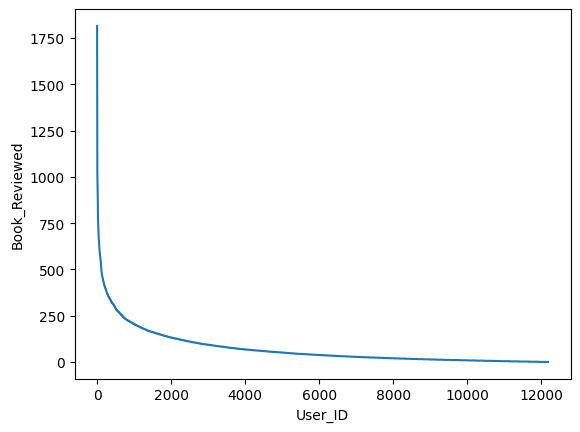

In [ ]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [ ]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [ ]:
# no review of the same book
book_per_user.max()

1

## Checking Reviews per Book

In [ ]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

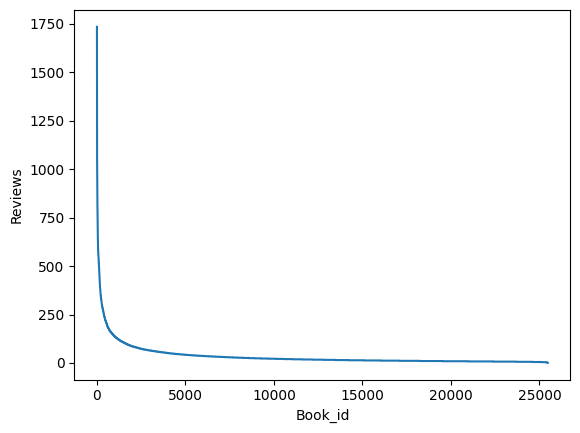

In [ ]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

# Preprocessing: Part I

## Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [ ]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [ ]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev, random_state = 42).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [ ]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

## Dropping NaN genres

In [ ]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [ ]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


## Cleaning Text

In [ ]:
#cleaning review_text col
df.review_text = df.review_text.swifter.apply(lambda x: clean_tokens(x))
df.head()

Pandas Apply:   0%|          | 0/430525 [00:00<?, ?it/s]

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre,n_review_per_book
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book. it started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,Science Fiction,20
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,recommended by don katz. avail for free in dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,Classics,54
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"a fun, fast paced science fiction thriller. i ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,Science Fiction,34
3,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"i really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,Science Fiction,9
6,8842281e1d1347389f2ab93d60773d4d,5577844,52c8ac49496c153e4a97161e36b2db55,5,a beautiful story. neil gaiman is truly a uniq...,Wed Sep 24 09:29:29 -0700 2014,Wed Oct 01 00:31:56 -0700 2014,Tue Sep 30 00:00:00 -0700 2014,Sun Sep 21 00:00:00 -0700 2014,5,1,Fantasy,14


## Dropping duplicated reviews and some self-referencing reviews 

There are outlier reviews (some spam or other stuf) when there is a referens to review or reviews

In [ ]:
idx_duplicated = df.loc[df.review_text.duplicated()].index
print(f'Duplicates removed: {len(idx_duplicated)}')
df.drop(index = idx_duplicated, inplace = True)

Duplicates removed: 6234


In [ ]:
idx_selfref = [(idx) for idx, row in df.iterrows() if ('review' in row.review_text)]
print(f'Self-referencing reviews removed: {len(idx_selfref)}')
df.drop(index = idx_selfref, inplace = True)

Self-referencing reviews removed: 81033


## Checking avg and max length of reviews

In [ ]:
review_length = df.review_text.transform(len)

In [ ]:
min_revlen = review_length.min()
min_revlen

0

In [ ]:
mean_revlen = review_length.mean()
mean_revlen

860.9390167162892

In [ ]:
median_revlen = review_length.median()
median_revlen

506.0

In [ ]:
max_revlen = review_length.max()
max_revlen

15028

## Dropping too short and too long reviews
At least they should be contained between the 1th and 95th percentile

In [ ]:
third_percentile = review_length.quantile(0.50)
third_percentile

506.0

In [ ]:
ninetyfifth_percentile = review_length.quantile(0.90)
ninetyfifth_percentile

2126.0

In [ ]:
greater_than_third = review_length.values > third_percentile
lower_than_last = review_length.values < ninetyfifth_percentile

In [ ]:
indices = [df.index[x] for x in np.where(greater_than_third & lower_than_last)[0]]

In [ ]:
df = df.loc[indices]
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 137115


## Storing the new training set

In [ ]:
rev_df = df[["review_text","genre", "rating", "book_id"]]
del df

In [ ]:
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
6,a beautiful story. neil gaiman is truly a uniq...,Fantasy,5,5577844
14,"a fun, dark, slightly comical western about tw...",Fiction,3,9850443
17,great story of the us ambassador to germany an...,History,4,9938498
21,i read a bunch of bond books in high school an...,Fiction,5,177193


In [ ]:
len(rev_df)

137115

## Filtering the genres

In [ ]:
list(enumerate(rev_df.genre.value_counts().items()))[:10]

[(0, ('Romance', 33932)),
 (1, ('Fantasy', 31653)),
 (2, ('Young Adult', 19193)),
 (3, ('Fiction', 10116)),
 (4, ('Science Fiction', 6886)),
 (5, ('Mystery', 6119)),
 (6, ('Sequential Art', 4975)),
 (7, ('Historical', 4759)),
 (8, ('Horror', 3459)),
 (9, ('Classics', 2447))]

In [ ]:
# made it slightly more readable
genres_corresp = ((("Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fantasy")),
                  (("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime"), #-->
                   ("Thriller")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Horror")),
                  (("Classics", "Contemporary", "Poetry", "Plays"), #-->
                   ("Literature")),
                  (("Nonfiction", "Autobiography", "Biography"), #-->
                   ("NonFiction")),
                  (("Historical", "History", "War", "Mythology"), #-->
                   ("History")))

In [ ]:
genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}
genres_to_keep_dict

{'Fantasy': 'Fantasy',
 'Superheroes': 'Fantasy',
 'Shapeshifters': 'Fantasy',
 'Science Fiction Fantasy': 'Fantasy',
 'Romance': 'Romance',
 'Erotica': 'Romance',
 'Polyamorous': 'Romance',
 'Category Romance': 'Romance',
 'Fiction': 'Fiction',
 'Young Adult': 'Fiction',
 'New Adult': 'Fiction',
 'Womens Fiction': 'Fiction',
 'Adult Fiction': 'Fiction',
 'Christian Fiction': 'Fiction',
 'Realistic Fiction': 'Fiction',
 'Fan Fiction': 'Fiction',
 'Magical Realism': 'Fiction',
 'Sequential Art': 'Art',
 'Music': 'Art',
 'Couture': 'Art',
 'Thriller': 'Thriller',
 'Mystery': 'Thriller',
 'Crime': 'Thriller',
 'Science Fiction': 'Science Fiction',
 'Horror': 'Horror',
 'Paranormal': 'Horror',
 'Dark': 'Horror',
 'Suspense': 'Horror',
 'Classics': 'Literature',
 'Contemporary': 'Literature',
 'Poetry': 'Literature',
 'Plays': 'Literature',
 'Nonfiction': 'NonFiction',
 'Autobiography': 'NonFiction',
 'Biography': 'NonFiction',
 'Historical': 'History',
 'History': 'History',
 'War': 'Histo

In [ ]:
print(f"Initial rows: {len(rev_df)}")
rev_df = rev_df[rev_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
print(f"Filtered len: {len(rev_df)}")

Initial rows: 137115
Filtered len: 134177


In [ ]:
rev_df.genre = rev_df.genre.map(lambda genere: genres_to_keep_dict[genere])
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
1,a beautiful story. neil gaiman is truly a uniq...,Fantasy,5,5577844
2,"a fun, dark, slightly comical western about tw...",Fiction,3,9850443
3,great story of the us ambassador to germany an...,History,4,9938498
4,i read a bunch of bond books in high school an...,Fiction,5,177193


In [ ]:
rev_df.genre.value_counts()

Romance            34886
Fiction            32481
Fantasy            31685
Thriller            7246
Science Fiction     6886
Horror              5950
Art                 4986
History             4979
Literature          3069
NonFiction          2009
Name: genre, dtype: int64

## Average Length of reviews per genere

In [ ]:
rev_length = rev_df.review_text.transform(len)

length_df = pd.DataFrame()

max_length = rev_df.genre.value_counts()[0]

for genre in rev_df.genre.unique():
    records = rev_length[rev_df['genre'] == genre].values.tolist()
    increase_wnan = [np.nan]*(max_length-len(records))
    records += increase_wnan
    length_df[genre] = records

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


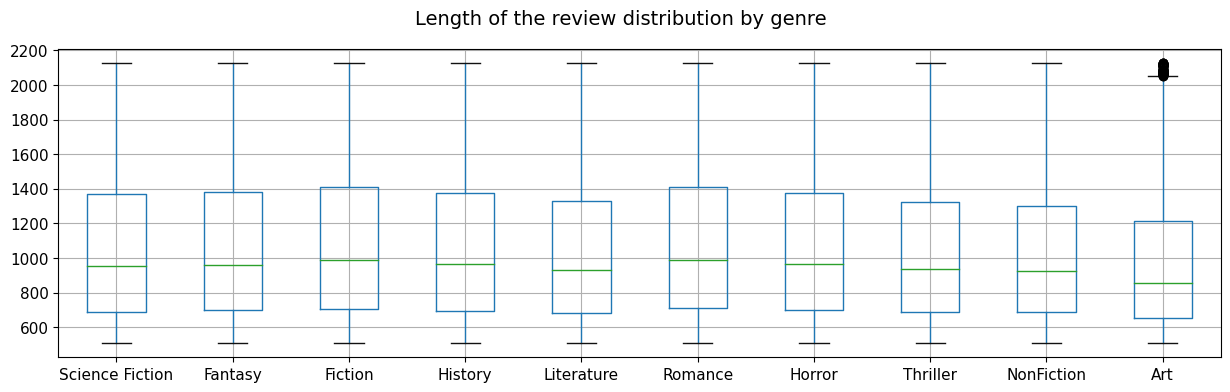

In [ ]:
fig = plt.figure(figsize=(15, 4)) 
fig.suptitle('Length of the review distribution by genre', fontsize=14)
length_df.boxplot(column=[col for col in length_df.columns], fontsize=11)
plt.show()

del length_df

## Merging Classes
After checking performances on validation we concluded it was too difficult to produce results with these many genres

In [ ]:
rev_df.genre.unique()

array(['Science Fiction', 'Fantasy', 'Fiction', 'History', 'Literature',
       'Romance', 'Horror', 'Thriller', 'NonFiction', 'Art'], dtype=object)

In [ ]:
new_genres = {'Romance': 'Romance',
              'Fiction' : 'Fiction',
              'Fantasy' : 'Fiction',
              'Thriller' : 'Mystery',
              'Horror' : 'Mystery', 
              'NonFiction' : 'NonFiction',
              'Literature' : 'NonFiction',
              'History' : 'NonFiction', 
              'Classics' : 'NonFiction', 
              'Science Fiction' : 'Science Fiction', 
              'Art' : 'Art'}

In [ ]:
rev_df['genre'] = rev_df.genre.map(lambda genere: new_genres[genere])

In [ ]:
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
1,a beautiful story. neil gaiman is truly a uniq...,Fiction,5,5577844
2,"a fun, dark, slightly comical western about tw...",Fiction,3,9850443
3,great story of the us ambassador to germany an...,NonFiction,4,9938498
4,i read a bunch of bond books in high school an...,Fiction,5,177193


## Plotting Genres distribution: Before Undersampling

In [ ]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

In [ ]:
rev_df.genre.value_counts()

Fiction            64166
Romance            34886
Mystery            13196
NonFiction         10057
Science Fiction     6886
Art                 4986
Name: genre, dtype: int64

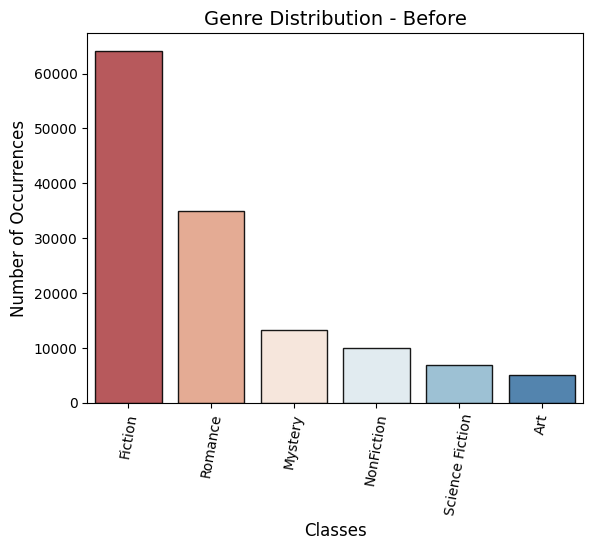

In [ ]:
sns.barplot([x for x in rev_df.genre.value_counts().index],
            [y for y in rev_df.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

## Class Undersampling

In [ ]:
n = 2000
genres_w_more_than_n_reviews = rev_df.groupby('genre')['genre'].transform(len) >= n
#undersampling genres with more than 2000 reviews to 2000
rev_df_reduced = pd.concat((rev_df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n, random_state = 42), 
                            rev_df[~genres_w_more_than_n_reviews]), ignore_index=True)

## Plotting Genres distribution: After Undersampling

In [ ]:
rev_df_reduced.genre.value_counts()

Art                2000
Fiction            2000
Mystery            2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Name: genre, dtype: int64

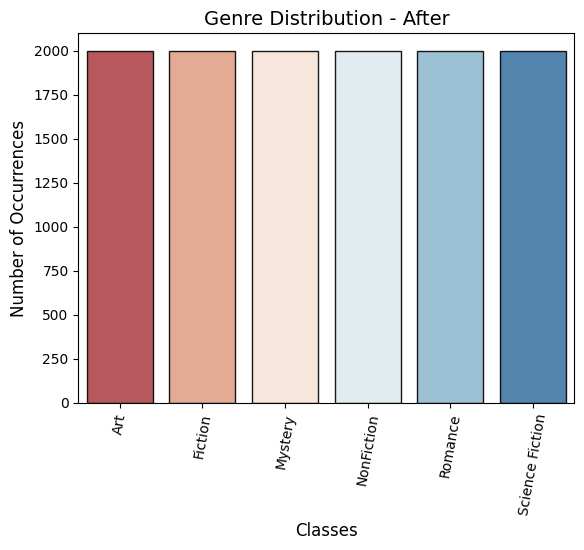

In [ ]:
sns.barplot([x for x in rev_df_reduced.genre.value_counts().index],
            [y for y in rev_df_reduced.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

# Preprocessing: Part II

In [ ]:
rev_df = rev_df_reduced
del rev_df_reduced

## Tokeninzing the Text

In [ ]:
rev_df["tokenized_text"] = rev_df.review_text.swifter.apply(lambda x: word_tokenize(x))
rev_df.head()

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"[breezy, hijinks, ,, fun, to, read, ., think, ..."
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"[for, the, story, ,, for, the, artwork, ., you..."
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"[rat, queens, so, the, rat, queens, are, to, f..."
3,i knew nothing about eternals before reading t...,Art,2,47694,"[i, knew, nothing, about, eternals, before, re..."
4,"better than the last book, this one moves the ...",Art,3,12137592,"[better, than, the, last, book, ,, this, one, ..."


## POS tagging

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [ ]:
rev_df["postagged_text"] = rev_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Dropping the tokenized text as we have an annotated version

In [ ]:
rev_df.drop('tokenized_text', axis = 1, inplace = True)

In [ ]:
list_of_tags = rev_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [ ]:
list(pos_mapper.items())[:5]

[("''", None), ('LS', None), ('TO', None), ('PDT', None), ('NNS', 'n')]

## Removing Stop Words

In [ ]:
print(f"e.g. a token list len before: {len(rev_df.postagged_text[0])}")
rev_df["postagged_text"] = remove_stop_words(rev_df["postagged_text"], pos = True)
print(f"e.g. a token list len after: {len(rev_df.postagged_text[0])}")

e.g. a token list len before: 153
e.g. a token list len after: 56


## Filtering out short words

In [ ]:
rev_df.head()

,review_text,genre,rating,book_id,postagged_text
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"[(breezy, NN), (hijinks, NNS), (fun, NN), (rea..."
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"[(story, NN), (artwork, NN), (know, VBP), (bes..."
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"[(rat, NN), (queens, NNS), (rat, NN), (queens,..."
3,i knew nothing about eternals before reading t...,Art,2,47694,"[(knew, VBD), (eternals, NNS), (reading, VBG),..."
4,"better than the last book, this one moves the ...",Art,3,12137592,"[(better, JJR), (book, NN), (moves, VBZ), (plo..."


In [ ]:
# minimum length of the remaining words of the fixed tokenized text 
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [ ]:
#filtering the words with a length less than 2
rev_df["postagged_text"] = rev_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])

Checking if both the tokenized text and the postagged one matches the new filtering

In [ ]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

3

## Lemmatize the Tokens

In [ ]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [ ]:
#lemmatizing
rev_df['lemmatized_text'] = rev_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
rev_df.drop('postagged_text', axis = 1, inplace = True)

In [ ]:
rev_df.head()

,review_text,genre,rating,book_id,lemmatized_text
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"[breezy, hijinks, fun, read, think, finish, si..."
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"[story, artwork, know, best, best, come, later..."
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"[rat, queen, rat, queen, fight, man, kidnap, b..."
3,i knew nothing about eternals before reading t...,Art,2,47694,"[know, eternals, read, pretty, get, neil, gaim..."
4,"better than the last book, this one moves the ...",Art,3,12137592,"[good, book, move, plot, forward, ntroduces, d..."


# Saving the Training Set

In [ ]:
rev_df.to_csv('./training_set_preprocessed.csv', index = False)

# EDA: Part II

## NER

Before cleaning the review texts, NER and chuncking are applied on some reviews

In [ ]:
#load spacy model 
nlp = spacy.load("en_core_web_sm")

In [ ]:
try_these = rev_df['review_text'].transform(lambda x: len(x.split())).sort_values()[0:2000].index

In [ ]:
for i in try_these:
    entities = nlp(rev_df.review_text[i]).ents
    if len(entities) > 1:
        print(i, entities)

824 (the later and early century, greek, bertrand russell, von neumann.)
10237 (first, third)
7783 (manhattan, elizabeth, diana penelope, henry schoonmaker, agnes jones, two)
1310 (asian, asian)
270 (japanese, otaku, first, japanese, inio asano's, niigahara)
10426 (three years, three, durreson, welldrawn, two, two, the years)
7298 (first, one)
5263 (stephen king, one)
870 (two, one)
10873 (about two, two)
185 (one, two, sailor moon)
10409 (today, butler, christian, america, dystopian)
4253 (decades, nine yards)
6878 (david copperfield', one, dickens, dickens, david copperfield', dickens)
4752 (prototupo kai diaskedastiko, kharakteres, bathos kai alethophaneia, mou, arese, exegesei giati o tzonathan, paidi, mou, mia ataka tou, stephen king)
11893 (first, two, first, first, dystopian, one)
6452 (english, julian, americans)
6097 (allen ginsberg, america)
6416 (three, australia)
2041 (fantastic urban fantasy, hollywood)
7235 (three, ya bibliophile)
7309 (three, three, haiti, christmas, chr

In [ ]:
rev_df.loc[11125]

review_text        as the story opens on cygnus beta, the sadiri ...
genre                                                Science Fiction
rating                                                             4
book_id                                                     15743440
lemmatized_text    [story, open, cygnus, beta, sadiri, lose, home...
Name: 11125, dtype: object

In [ ]:
# Doc example for chunking and NER visualization
eg_rev = 11125
doc = nlp(rev_df.review_text[eg_rev])

In [ ]:
print(doc.ents)

(nonsadiri, enter dllenakhsadiri representativeelder, delaruabiotechniciancygnian, dllenakh)


In [ ]:
# Chunking 
[chunk.text for chunk in doc.noun_chunks]

['the story',
 'cygnus beta',
 'the sadiri',
 'their home world',
 'the daunting task',
 'a new life',
 'a planet',
 'that',
 'the one',
 'they',
 'so few potential mates',
 'the sadiri',
 'they',
 'extinction',
 'a people',
 'the loss',
 'their culture',
 'they',
 'nonsadiri',
 'dllenakhsadiri representativeelder',
 'delaruabiotechniciancygnian representative',
 'dllenakh',
 'the sadiri',
 'cygnus',
 'delarua',
 'sadiri needs',
 'them',
 'hard truths',
 'solutions',
 'their issues',
 'i',
 'myself',
 'i',
 'something',
 'the details',
 'the end',
 'the book',
 'everything',
 'the place',
 'i',
 'the details',
 'i',
 'i',
 'details',
 'delarua',
 'dllenahkh',
 'it',
 'all a part',
 'delarua',
 'she',
 'her understanding',
 'the sadiri',
 'herself',
 'overall, great reading']

In [ ]:
rev_df['lemmatized_text'].loc[eg_rev]

['story',
 'open',
 'cygnus',
 'beta',
 'sadiri',
 'lose',
 'home',
 'world',
 'face',
 'daunt',
 'task',
 'start',
 'new',
 'life',
 'planet',
 'vastly',
 'different',
 'know',
 'potential',
 'mate',
 'sadiri',
 'risk',
 'extinction',
 'people',
 'andor',
 'loss',
 'culture',
 'decide',
 'mate',
 'nonsadiri',
 'enter',
 'dllenakhsadiri',
 'representativeelder',
 'delaruabiotechniciancygnian',
 'representative',
 'dllenakh',
 'task',
 'mentoringcounseling',
 'sadiri',
 'cygnus',
 'delarua',
 'task',
 'interpret',
 'sadiri',
 'need',
 'want',
 'provide',
 'hard',
 'truth',
 'solution',
 'issue',
 'occasionally',
 'feel',
 'like',
 'miss',
 'detail',
 'end',
 'book',
 'fell',
 'place',
 'nicely',
 'realize',
 'detail',
 'felt',
 'miss',
 'detail',
 'delarua',
 'know',
 'dllenahkh',
 'reveal',
 'learn',
 'delarua',
 'grow',
 'understanding',
 'sadiri',
 'overall',
 'great',
 'reading']

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

nonsadiri PERSON
enter dllenakhsadiri representativeelder PERSON
delaruabiotechniciancygnian NORP
dllenakh ORG


In [ ]:
# The 'ent' style shows a named entity visualization
displacy.render(doc, style="ent", jupyter=True )

In [ ]:
# Doc example for dependency parse tree
example = nlp(rev_df.review_text[eg_rev])

In [ ]:
# The 'dep' style shows a dependency parse tree with POS(Part-of-Speech) tags and syntactic dependencies 
displacy.render(example, style="dep", jupyter=True, options= {'distance': 110} )

In [ ]:
rev_df.review_text[eg_rev]

"as the story opens on cygnus beta, the sadiri have just lost their home world and are faced with the daunting task of starting a new life on a planet that is vastly different from the one they knew. oh, and there are so few potential mates for the sadiri that they risk extinction as a people andor the loss of their culture if they decide to mate with nonsadiri. enter dllenakhsadiri representativeelder and delaruabiotechniciancygnian representative. dllenakh is tasked with mentoringcounseling the sadiri on cygnus, and delarua is tasked with interpreting sadiri needs and wants, providing them with hard truths and solutions to their issues. i occasionally found myself feeling like i'd missed something in the details, but towards the end of the book, everything fell into the place nicely and i realized that the details i felt i was missing were details delarua did not quite know or dllenahkh had not quite revealed. it was all a part of learning along with delarua as she grew in her unders

## Extracting Dictionary 

In [ ]:
dict_count = dict(sorted(nltk.FreqDist([word for text in rev_df["lemmatized_text"] for word in text]).items(), 
                         key=lambda x: x[1], reverse=True))

In [ ]:
list(dict_count.items())[:6]

[('book', 24907),
 ('read', 13174),
 ('like', 13084),
 ('story', 12573),
 ('character', 10165),
 ('love', 9837)]

In [ ]:
# getting the max frequency of a word that appear in at most 80% of the review corpus 
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [ ]:
# filtering out the extremes of the distribution
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [ ]:
dictionary = set(dict_count_fixed.keys())
# dictionary
len(dictionary)

10447

## Visualizations for the Genre

In [ ]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer()

In [ ]:
# joining the text back to a string
rev_df['lemmatized_joined'] = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))

# setting the corpus and the labels
corpus = rev_df["lemmatized_joined"]
labels = rev_df['genre']

# vectorizing
matrix = tfidf.fit_transform(corpus)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Lots of insight could be derived from the following UMAP projection. It's not possible to fix the projection across multiple runs, thus a picture of one of the outputs is being shown:

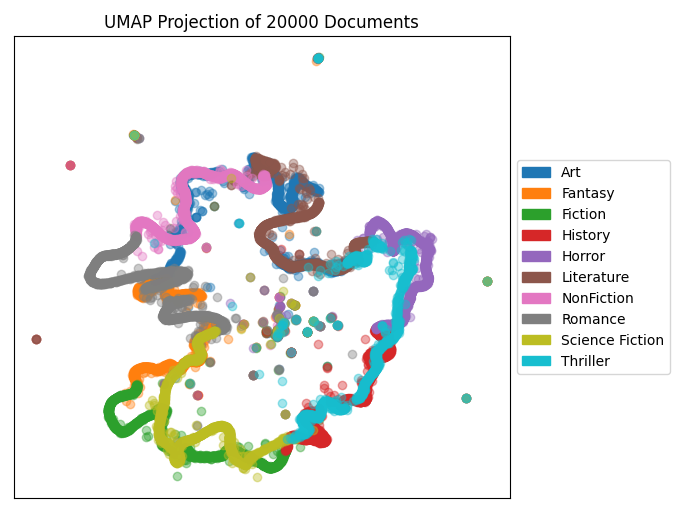

There seems to be some sort of ring connection between the different genres, as it can be seen Romance and Fantasy overlaps in some parts while Thriller overlaps entirely with both History and Horror, Science fiction instead seems to be the closse to Fiction, while Literature and non-fiction seems to converge and mix together on Art

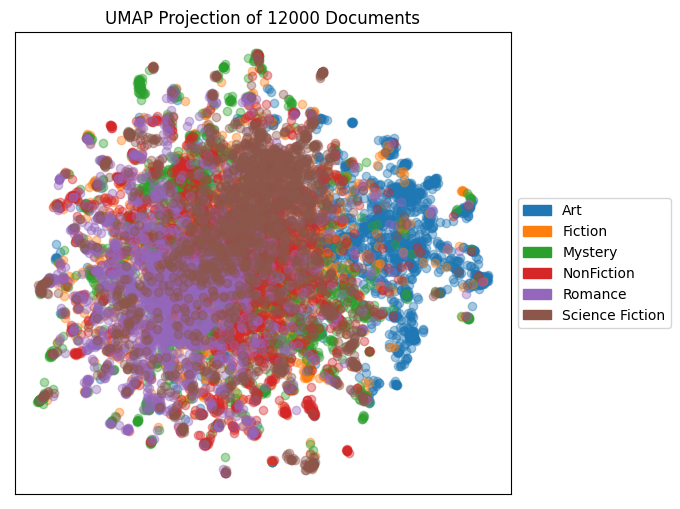

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
umap = UMAPVisualizer(ax = ax, alpha = 0.4)
umap.fit(matrix, labels, random_state = 42)
umap.show()

Regarding tSNE nothing of relevance appeared from the plot out of the fact that it seems there is some stronger internal connection with reviews related with Art and Thriller

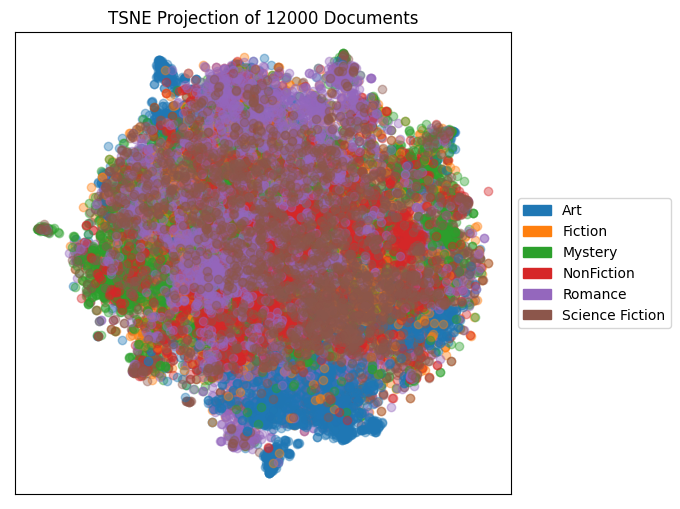

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
tsne = TSNEVisualizer(ax = ax, alpha = 0.4)
tsne.fit(matrix, labels, random_state = 42)
tsne.fit(matrix, labels, random_state = 42)
tsne.show()

## Topic Modeling

In [ ]:
lemma_docs = rev_df["lemmatized_text"].values.tolist()

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(lemma_docs, min_count=20)

for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            # I keep both single words and bigrams in the document
            lemma_docs[idx].append(token)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
alternative_dictionary = Dictionary(lemma_docs)
print('Before Removal', len(alternative_dictionary))
# Filter out words that occur less than 5 documents, or more than 70% of the documents.
alternative_dictionary.filter_extremes(no_below=5, no_above=0.70)
print('After Filtering', len(alternative_dictionary))
not_filter = set(alternative_dictionary.values()).intersection(dictionary)
not_filter_idx = [alternative_dictionary.token2id[token] for token in not_filter]
alternative_dictionary.filter_tokens(good_ids=not_filter_idx)
print('After Intersection', len(alternative_dictionary))

Before Removal 43304
After Filtering 11334
After Intersection 9782


In [ ]:
# Bag-of-words representation of the documents.
corpus = [alternative_dictionary.doc2bow(doc) for doc in lemma_docs]

In [ ]:
for key, idxinfo in zip([alternative_dictionary[w[0]] for w in corpus[5]], corpus[5]):
    print (key, idxinfo)

drawing (7, 1)
accept (160, 3)
american (161, 7)
animation (162, 1)
association (163, 2)
award (164, 3)
banana (165, 2)
bear (166, 1)
behave (167, 1)
boat (168, 1)
born (169, 1)
capture (170, 1)
center (171, 1)
characteristic (172, 1)
china (173, 1)
chinese (174, 5)
community (175, 1)
connection (176, 1)
cousin (177, 1)
culture (178, 3)
danny (179, 2)
desperately (180, 2)
division (181, 1)
easily (182, 1)
essential (183, 1)
excite (184, 1)
expertly (185, 1)
expressive (186, 1)
fresh (187, 1)
heaven (188, 1)
honor (189, 1)
illustration (190, 1)
imagination (191, 1)
imaginative (192, 1)
ink (193, 1)
jin (194, 2)
library (195, 2)
literary (196, 1)
literature (197, 1)
loss (198, 1)
michael (199, 1)
monkey (200, 1)
mountain (201, 1)
outrageously (202, 1)
peer (203, 1)
printz (204, 2)
realistically (205, 1)
ruler (206, 1)
sequence (207, 2)
service (208, 1)
smoothly (209, 1)
student (210, 2)
suburban (211, 1)
term (212, 1)
texas (213, 1)
transform (214, 1)
visit (215, 1)
vivid (216, 1)
wang (

In [ ]:
print(f'Number of unique tokens: {len(alternative_dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 9782
Number of documents: 12000


In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = len(np.unique(rev_df['genre']))
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = alternative_dictionary[0]  # This is only to "load" the dictionary.
id2word = alternative_dictionary.id2token

model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes,
                 eval_every=eval_every
                 )

In [ ]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'Average topic coherence: {avg_topic_coherence:.4f}.')

Average topic coherence: -9.7516.


I see some words which appear in a lot of books going to the same topic, while I can recognize some thriller and romance -like words...

In [ ]:
topic_clust_words = list()
cluster = 0

for topic in top_topics:
    print('\n', topic[1], [w[1] for w in topic[0]])
    representative_word = [w[1] for w in topic[0]][0]
    cluster += 1
    topic_clust_words.append((cluster, representative_word))


 -3.6130491065064883 ['scifi', 'culture', 'explore', 'complex', 'form', 'conflict', 'similar', 'describe', 'somewhat', 'mile', 'earth', 'classic', 'building', 'entirely', 'believable', 'suspense', 'planet', 'picture', 'conclusion', 'level']

 -4.134256969900999 ['stupid', 'pov', 'yeah', 'kinda', 'damn', 'fuck', 'shit', 'trust', 'deserve', 'jane', 'wow', 'tear', 'alpha', 'as', 'angst', 'hurt', 'amaze', 'plus', 'cliffhanger', 'skip']

 -9.079133891424512 ['eve', 'mary', 'college', 'husband', 'alex', 'anne', 'french', 'emma', 'marry', 'dog', 'mental', 'kate', 'letter', 'childhood', 'david', 'rachel', 'contemporary', 'amy', 'illness', 'period']

 -9.483137684696828 ['captain', 'military', 'harry', 'joe', 'america', 'battle', 'earth', 'mia', 'marvel', 'scalzi', 'mission', 'soldier', 'enemy', 'crew', 'sam', 'north', 'ash', 'wolf', 'iron', 'queen']

 -15.400770540422736 ['adam', 'jake', 'anna', 'juliette', 'ben', 'peter', 'duke', 'mate', 'james', 'jason', 'police', 'dan', 'robin', 'detective

### Get insight on the genres with topic words

In [ ]:
topic_clust_words

[(1, 'scifi'),
 (2, 'stupid'),
 (3, 'eve'),
 (4, 'captain'),
 (5, 'adam'),
 (6, 'lucy')]

In [ ]:
def frequency_per_genre(df, genre, avoid_first = 20):
    df_review = df[df.genre == genre]
    
    dict_count = dict(sorted(nltk.FreqDist([word for text in df_review["lemmatized_text"] for word in text]).items(), 
                             key=lambda x: x[1], reverse=True)[avoid_first:])
    
    return dict_count

In [ ]:
from tqdm import tqdm

cluster_assignment = list()

for genre in tqdm(rev_df['genre'].unique()):
    for cluster, topic_word in topic_clust_words:
        try:
            freq = frequency_per_genre(rev_df, genre)[topic_word]
        except:
            freq = 0
        cluster_assignment.append((cluster, genre, topic_word, freq))

100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Extracting for each word and genre pair the frequency of the word in the reviews of that genre, then extracting the maximum frequency for each genre

In [ ]:
topic_clust_assignment = pd.DataFrame(cluster_assignment, columns = ['cluster', 'genre', 'topic_word', 'freq'])
max_freq_of_genre = topic_clust_assignment[['genre', 'freq']].groupby('genre').max().reset_index()
max_freq_of_genre = max_freq_of_genre.merge(topic_clust_assignment, on=['genre', 'freq'])

In [ ]:
max_freq_of_genre.head(10)

,genre,freq,cluster,topic_word
0,Art,95,4,captain
1,Fiction,60,2,stupid
2,Mystery,160,3,eve
3,NonFiction,30,2,stupid
4,Romance,63,2,stupid
5,Science Fiction,259,1,scifi


Getting the maximum frequency topic_word per genre, considering the selection of topic words is a almost randomized process we decided to save some results to make some considerations:

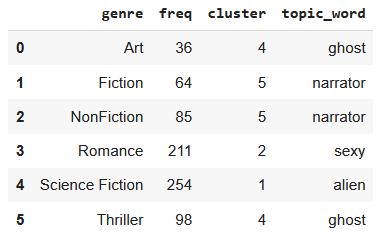

As it can be seen there are some words that seem to be semantically strictly connected with some genres, like ghost and narrator

## Considerations on TF-IDF values on unigrams, bigrams and trigrams

In [ ]:
# convert into numpy array with todense()
tfidf_values = pd.DataFrame(matrix[32].T.todense(),
                            index=tfidf.get_feature_names(), columns=["TF-IDF"]) 
tfidf_values = tfidf_values.sort_values('TF-IDF', ascending=False)
tfidf_values[:10]

,TF-IDF
sexist,0.547043
bolding,0.185927
flaw,0.183800
bother,0.180536
stand,0.158970
compendium,0.157096
noticeable,0.148627
wee,0.139963
offend,0.138295
emphasize,0.134018


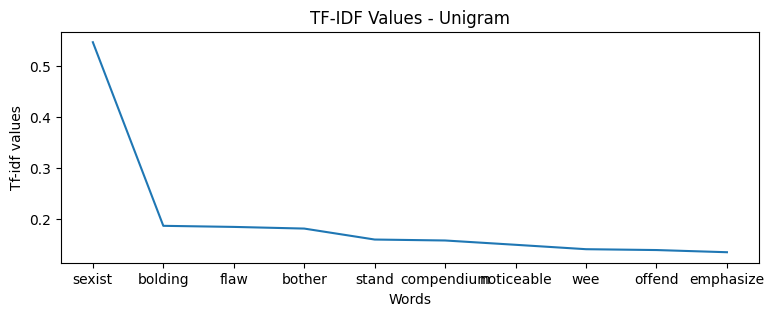

In [ ]:
p = [x for x in tfidf_values.values][:10]
n = [x for x in tfidf_values.index][:10]
plt.figure(figsize=(9,3))
plt.title("TF-IDF Values - Unigram")
plt.xlabel("Words")
plt.ylabel("Tf-idf values")
plt.plot(n,p)
plt.show()

The higher the TF-IDF score the more important/ relevant the term is. When a term gets less relevant, its TF-IDF score will tend to 0. 

In [ ]:
corpus = rev_df['lemmatized_joined']

In [ ]:
# initialize tfidf considering bigrams
tfidf_bi = TfidfVectorizer(ngram_range = (2,2))
matrix_bi = tfidf_bi.fit_transform(corpus)

tfidf_values_bi = pd.DataFrame(matrix_bi[32].T.todense(),
                               index=tfidf_bi.get_feature_names(), columns=["TF-IDF_Bigrams"]) 
tfidf_values_bi = tfidf_values_bi.sort_values('TF-IDF_Bigrams', ascending=False)
tfidf_values_bi[:10]

,TF-IDF_Bigrams
time fluff,0.117602
humanity ridiculously,0.117602
bolding dialogue,0.117602
actually sexist,0.117602
stand realistic,0.117602
compendium noticeable,0.117602
invest survive,0.117602
characterization stand,0.117602
flaw justify,0.117602
offend bother,0.117602


In [ ]:
# initialize tfidf considering bigrams
tfidf_tri = TfidfVectorizer(ngram_range = (3,3))
matrix_tri = tfidf_tri.fit_transform(corpus)

tfidf_values_tri = pd.DataFrame(matrix_tri[32].T.todense(),
                                index=tfidf_tri.get_feature_names(), columns=["TF-IDF_Trigrams"]) 
tfidf_values_tri = tfidf_values_tri.sort_values('TF-IDF_Trigrams', ascending=False)
tfidf_values_tri[:10]

,TF-IDF_Trigrams
character hey wee,0.10824
series go stand,0.10824
pretty impress art,0.10824
time fluff read,0.10824
story flow characterization,0.10824
end compendium noticeable,0.10824
waste time fluff,0.10824
problem get sort,0.10824
wee bit whisper,0.10824
break character hey,0.10824


In both bigrams and trigrams , the tf-idf values are similar

## Sentiment Analysis
Testing on lemmatized text because of fewer tokens per documents (It will be tested on the original sentences later)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# For 12.000 records it requires half an hour or so
sample_sentiment = rev_df['lemmatized_joined']
index_sample = sample_sentiment.index

In [ ]:
start = time.time()
sentiment_score(sample_sentiment.loc[index_sample[0]])
end = time.time()
print(end-start)

1.4362130165100098


In [ ]:
sentiment_result = sample_sentiment.swifter.apply(lambda x: sentiment_score(x[:512]))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
sentiment_df = pd.concat((rev_df['review_text'].loc[index_sample], sentiment_result), axis= 1).rename(columns={'lemmatized_joined':"sentiment"}).reset_index(drop=True)

In [ ]:
sentiment_df.head()

,review_text,sentiment
0,"breezy hijinks, fun to read. think i finished ...",2
1,"for the story, for the artwork. you know how t...",1
2,rat queens so the rat queens are to fight the ...,3
3,i knew nothing about eternals before reading t...,3
4,"better than the last book, this one moves the ...",3


In [ ]:
sentiment_df.loc[sentiment_df.index[1]]['review_text'], sentiment_df.loc[sentiment_df.index[1]]['sentiment']

("for the story, for the artwork. you know how they say, your first may not always be the best the best comes later. dc 's rejuvenated new flash was my first flash comic. after having seen the amazing tv adaptation of the flash recently, my expectations were through the roof, but they came crashing down. unlike other superheroes, the trademark of flash a. k. a barry allen is his humor. flash is a man who is still a boy at heart ready to sweep you off your feet with his speed and his jokes. but sadly somewhere while making a rejuvenated leap, dc dropped the fun part. the flash volume one collects issues . the first five issues have a good story line but things get intolerable sixth issue onward. in the first five issues flash faces the mob. the story goes into the origins of flash more seriously. the mystery that is the speed force is quite complex and intriguing. flash is tapping the speed force and as a consequence breaking the very fabric of space and time. flash was not just running

In [ ]:
sentiment_df.loc[sentiment_df.index[3]]['review_text'], sentiment_df.loc[sentiment_df.index[3]]['sentiment']

("i knew nothing about eternals before reading this, and pretty much just got it because it's by neil gaiman. so i didn't know about the original series and still don't know much about it. some of the character designs and ideas are kinda cool, and the art works well enough, but i don't think gaiman managed to rescue this from the wtfery of its apparent origins. the longer he drew out the mystery, the better it was all the explanation was kinda. this is what you were setting up for really i don't think this works well in a world with registration and civil war and tony stark, either",
 3)

### Checking Ratings-Sentiment Metrics and Correlation
Trying to see if the sentiment analysis is a good predictor of the ratings:

It seems it is not

In [ ]:
from sklearn.metrics import classification_report

sentiment_df['rating'] = rev_df.rating.replace(0, 1)

print(classification_report(sentiment_df.rating, sentiment_df.sentiment))

              precision    recall  f1-score   support

           1       0.09      0.67      0.16       511
           2       0.17      0.25      0.20      1031
           3       0.36      0.26      0.30      2991
           4       0.51      0.27      0.36      4584
           5       0.53      0.39      0.45      2883

    accuracy                           0.31     12000
   macro avg       0.33      0.37      0.29     12000
weighted avg       0.43      0.31      0.34     12000



In [ ]:
sentiment_df.corr()

,sentiment,rating
sentiment,1.000000,0.330819
rating,0.330819,1.000000


## WorldCloud

In [ ]:
def generate_wordcloud_genre(df, genre, avoid_first = 20):
    f = frequency_per_genre(df, genre, avoid_first)
    mask = np.array(Image.open(genre + ".png"))
    wc = WordCloud(background_color="white", 
                   max_words=200, max_font_size=100, 
                   random_state=42, mask = mask).generate_from_frequencies(f)
    plt.figure(figsize=(20,6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(genre)
    plt.axis("off")
    plt.show()

In [ ]:
import urllib.request

# Downloading pictures for word clouds
fiction_url = 'https://cdn-icons-png.flaticon.com/512/523/523813.png'
art_url = 'https://www.freepnglogos.com/uploads/ghost-png/creepy-ghost-svg-png-icon-download-24.png'
mystery_url = 'https://assets-global.website-files.com/5eea2efbaac9091a52bc9645/625fbd4ad3c560021d7a058b_lente%20mobile.png'
romance_url = 'https://cdn-icons-png.flaticon.com/512/1216/1216686.png'
scifi_url = 'https://cdn-icons-png.flaticon.com/512/190/190276.png'

genre_url = {'Fiction' : fiction_url, 'Art' : art_url, 
             'Mystery' : mystery_url, 'Romance' : romance_url, 
             'Science Fiction' : scifi_url}

for genre, url in genre_url.items():
    urllib.request.urlretrieve(url, genre + '.png')

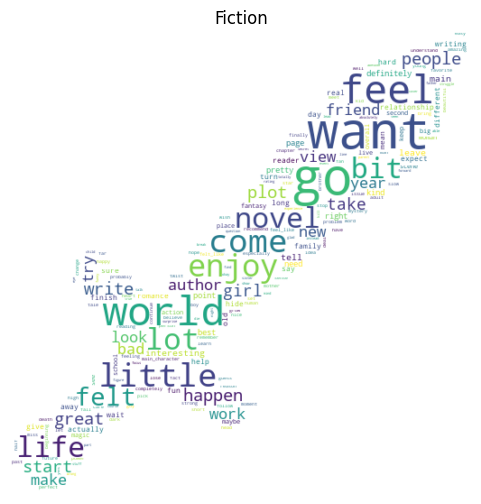

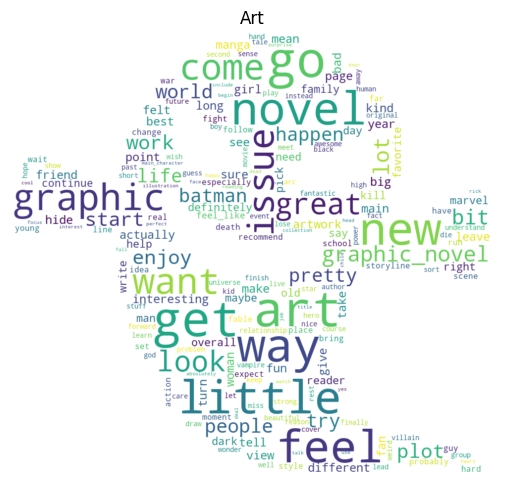

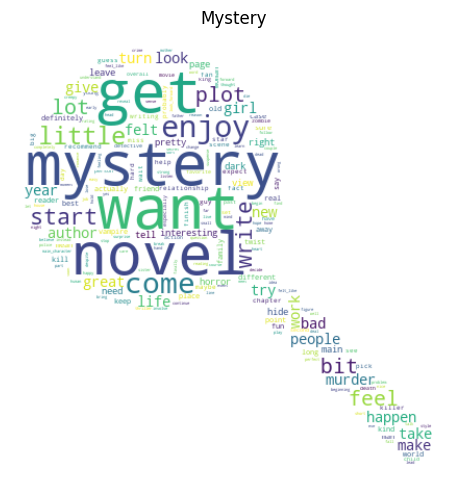

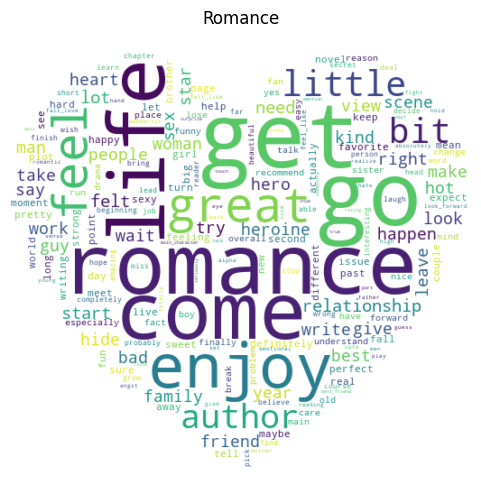

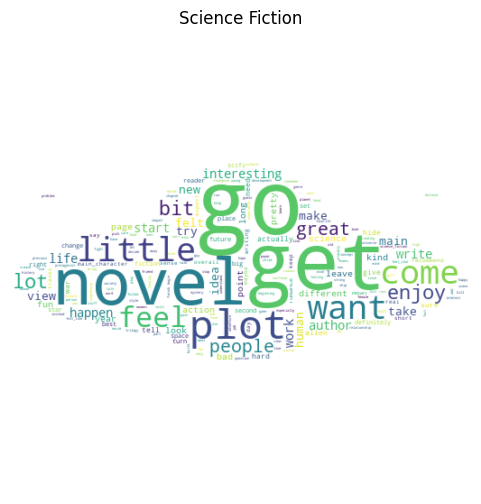

In [ ]:
for genre in genre_url.keys():
    generate_wordcloud_genre(rev_df, genre, 15)

# Clustering

## Summarize (managing dimensionality)

In [ ]:
!pip install gensim==3.4.0
!pip install sentence-transformers
!pip install bcubed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.2 MB 1.2 MB/s 
  Created wheel for gensim: filename=gensim-3.4.0-cp38-cp38-linux_x86_64.whl size=23477287 sha256=fb0a9e1a86e3a7095e815ee3191d059c2b3f98ab614bd6b72fe8fbf261859ba7
  Stored in directory: /root/.cache/pip/wheels/b4/a4/71/a301cdb2b7d5d31525936fcb8dcd9a5f144578d047407f7cf9
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 64.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=fa55be2677a69cef86cf1964d5f90ecf8a2ed65ef3db00f1b0de59d5ea817e18
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
logging.disable(logging.CRITICAL) # Input too short (less than 10 sentences), log warnings explosion

In [ ]:
from gensim import summarization

summaries = []
for review in tqdm(rev_df['review_text'], desc="Summarization"): # tqdm gives us a nice progress bar
    try:
        summary = summarization.summarize(review, ratio = 0.3, split = True, ) # summarize the sentences
    except Exception:
        summary = [review] # otherwise keep the full text
    
    if summary == []:
        summary = [review]
    summaries.append(summary)

rev_df['Summary-TextRank'] = summaries

Summarization: 100%|██████████| 12000/12000 [00:31<00:00, 378.28it/s]


In [ ]:
#define the pooling function to average sentence vectors
def pool(embeddings, method = "mean"):
    poolers = {
                "mean" : lambda x: np.mean(x, axis=0),
                "max"  : lambda x: np.max(x, axis=0),
                "min"  : lambda x: np.min(x, axis=0)
              }   
    return poolers[method](embeddings)

In [ ]:
from sentence_transformers import SentenceTransformer 

model = 'distilbert-base-nli-stsb-mean-tokens'
embedder = SentenceTransformer(model)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

## Create Embeddings

In [ ]:
embeddings_TextRank = []
for rev in tqdm(rev_df['Summary-TextRank'], desc="Embedding reviews"):
    sentences_embeddings = embedder.encode(summary) # summary is a list of sentences
    doc_embeddings = pool(sentences_embeddings)
    embeddings_TextRank.append(doc_embeddings)
embeddings_TextRank = np.array(embeddings_TextRank)
embeddings_TextRank.shape

Embedding reviews: 100%|██████████| 12000/12000 [01:40<00:00, 119.54it/s]


(12000, 768)

### Trying a Hierarchical Clustering

In [ ]:
rev_df['Summary-TextRank'][0]

["the author of this one is just a little older than i am, and i feel like you could psychoanalyze the shit out of what she's saying about gender in this piece.",
 "i liked it, but had to flip through it to remember what it was about, so apparently didn't find it particularly memorable"]

In [ ]:
rev_df['review_text'][0]

"breezy hijinks, fun to read. think i finished it in two sittings at most. the author of this one is just a little older than i am, and i feel like you could psychoanalyze the shit out of what she's saying about gender in this piece. or, more specifically, about being a woman in today's world. basically, there's this chick who's working as a modelofsorts, who is kinda sick of being objectified, and falls into a relationship with an ahem reclusive author, with an ahem complicated relationship with his fame. it's adult nudity nudity nudity, and blends a pretty muted jeweltoned color palette over freespirited, thinlined drawings. i liked it, but had to flip through it to remember what it was about, so apparently didn't find it particularly memorable"

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import bcubed

X = pdist(embeddings_TextRank, metric = 'cosine') #1-d condensed distance array (with cosine)

In [ ]:
Z = linkage(X, method = 'complete') # generate the linkage matrix

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


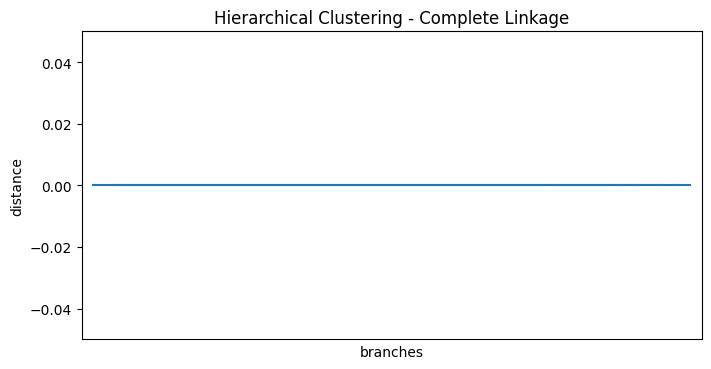

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f'Hierarchical Clustering - Complete Linkage')
plt.xlabel('branches')
plt.ylabel('distance')
dendrogram(Z, orientation = "top", no_labels = True, truncate_mode='lastp') # draw the dendrogram
plt.show()

## Measuring difference from original Genre Labels

In [ ]:
def eval_BCubed(clusters, ground_truth):    
    predicted = {i: set([str(c)]) for i, c in enumerate(clusters)}
    precision = bcubed.precision(predicted, ground_truth)
    recall = bcubed.recall(predicted, ground_truth)
    fscore = bcubed.fscore(precision, recall)
    return precision, recall, fscore

In [ ]:
categories = pd.factorize(rev_df['genre'])[0] #numerical categories for labels
ground_truth = {i: set([c]) for i, c in enumerate(categories)}

In [ ]:
clusters = fcluster(Z, t = 1.2, criterion = 'distance')
n_clusters = len(set(clusters))

In [ ]:
cut = 1.275
clusters = fcluster(Z, t = cut, criterion = 'distance')
n_clusters = len(set(clusters))
precision, recall, fscore = eval_BCubed(clusters, ground_truth)

clust_results = {"Distance": cut,
                 "Clusters": n_clusters,
                 "Precision": round(precision, 2),
                 "Recall": round(recall, 2),
                 "F1 Score": round(fscore, 2)}

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f'Hierarchical Clustering - Complete Linkage')
plt.xlabel('branches')
plt.ylabel('distance')
plt.axhline(y=1.275, color='r', linestyle='--')
dendrogram(Z, orientation = "top", no_labels = True, truncate_mode='lastp') # draw the dendrogram
plt.show()